# Average grain size distribution 

- I am using the dataframe created in the previous file to calculate the average HH corr
- Since I have different scansizes and pixel numbers (and therefore, different stepsize), I take the smallest stepsize and I create the interpolated HH corr function over this new scale.
- Once I have the interpolated functions, I can easily average them.

In [31]:
import os
import sys
import json

import numpy as np
import pandas as pd
import pickle

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


from matplotlib import cm
from skimage import data, img_as_float

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.stats import sem

In [32]:
debug = False 
z_score = 4
path = "/Users/sfiligoj/Google Drive/Crispies/Ru/Data analysis with Python/Pandas and Matplotlib - HHcorr, Basics and Images/DSP_all"
os.chdir(path)
# Load the dictionary back from the pickle file.
df = pickle.load(open(f"save_z{z_score}.p", "rb" ) )

if debug: print(f'select specific density')
if debug: df = df[df.density=='L']
df.head()

,filename,density,temp,xi,hhcorr,scansize,n_pix,rms,rms_sq,alpha
0,000,L,600,6.122128,"[0.11283684130547841, 0.2599262689582654, 0.36...",1000,512,0.471901,0.222690,0.600728
1,001,L,600,5.567443,"[0.16764409711734046, 0.37195395444029605, 0.5...",1000,512,0.528078,0.278866,0.573597
2,006,H,800,22.657056,"[0.19211592908350456, 0.6312847337329612, 1.23...",1000,512,2.537245,6.437613,0.857751
3,004,L,700,6.618951,"[0.181274623984686, 0.45133967345751996, 0.682...",1000,512,0.671260,0.450590,0.656817
4,005,L,700,6.805593,"[0.17847738320619247, 0.44273951972272735, 0.6...",1000,512,0.676116,0.457133,0.654194


# Pixel size selection:

In [33]:
# we add a new column to the dataframe that describes the px_size
df['px_size'] = df.scansize / df.n_pix
#I discard the following px_sizes because they are too big (I could see this when I plotted each HHcorr):
df.drop(df[df.px_size==5000/512].index, inplace=True) 
df.drop(df[df.px_size==10000/512].index, inplace=True)
df.drop(df[df.px_size==30000/512].index, inplace=True)
#I discard the following scan size:
df.drop(df[df.scansize==200].index, inplace=True)
df

,filename,density,temp,xi,hhcorr,scansize,n_pix,rms,rms_sq,alpha,px_size
0,000,L,600,6.122128,"[0.11283684130547841, 0.2599262689582654, 0.36...",1000,512,0.471901,0.222690,0.600728,1.95312
1,001,L,600,5.567443,"[0.16764409711734046, 0.37195395444029605, 0.5...",1000,512,0.528078,0.278866,0.573597,1.95312
2,006,H,800,22.657056,"[0.19211592908350456, 0.6312847337329612, 1.23...",1000,512,2.537245,6.437613,0.857751,1.95312
3,004,L,700,6.618951,"[0.181274623984686, 0.45133967345751996, 0.682...",1000,512,0.671260,0.450590,0.656817,1.95312
4,005,L,700,6.805593,"[0.17847738320619247, 0.44273951972272735, 0.6...",1000,512,0.676116,0.457133,0.654194,1.95312
5,001,L,25,5.487015,"[0.10030677120404796, 0.24009558688245503, 0.3...",1000,512,0.428379,0.183509,0.627600,1.95312
6,017,H,600,22.684063,"[0.17921500378127392, 0.5074865966813252, 0.90...",1000,512,1.885520,3.555185,0.750453,1.95312
7,003,L,700,6.723602,"[0.17634331972145695, 0.4408674722748601, 0.66...",1000,512,0.671355,0.450717,0.659746,1.95312
8,002,L,25,6.010758,"[0.23905742689953732, 0.4187395410860898, 0.53...",1000,512,0.544370,0.296339,0.403803,1.95312
9,LAT,H,25,6.737813,"[0.031305503576262016, 0.06935480520654615, 0....",1000,512,0.254202,0.064618,0.572338,1.95312


# Calculation of interpolated HHcorr's
- Since x_new was different for L, LH and H I had to crate a loop through the densities.

In [34]:
densities = ['L','H']
df['hhcorr_interp'] = 'default value'
x_new={}
for d in densities:
    sel = df[df.density==d]
    # we create Xdelta for each row, all at once
    x_delta = [np.arange(px_size, scan_size+px_size, px_size) for px_size, scan_size in zip(sel.px_size, sel.scansize)] 
    # we take the minimun px_size, and interpolate all HHcorr at x values whose delta is that minimum
    min_dx = min(sel.px_size)
    min_scansize = min(sel.scansize)
    if debug: print(min_dx, min_scansize)
    x_new[d] = np.arange(min_dx, min_scansize, min_dx) # x_new is the new range on which I want to interpolate the data   
    #definition of HHcorr-interpolated+addition to data-frame:
    df['hhcorr_interp'].loc[sel.index] = [np.interp(x_new[d], x, y) for x,y in zip(x_delta, sel.hhcorr)] 
    

/anaconda3/envs/pina/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Calculation of Average HHcorr
    Blueprint -> AvHHcorr [density] [temperature]
    - we take the interpolated HHcorr from the "selection" DataFrame
    - we create an array, where each HHcorr from a different measurement is a full row
    - when we average on the columns, we get the average_HHcorr

In [39]:
temperatures = ['25','600','700','800']
densities = ['L','H']

AvHHcorr = {} 
AvRMS = {}
AvCorrLen={}
AvRMSsq={}
AvAlpha={}
for dens in densities:
    AvHHcorr[dens] = {}
    AvRMS[dens] = {}
    AvCorrLen[dens]={}
    AvRMSsq[dens]={}
    AvAlpha[dens]={}
    for temp in temperatures:
        AvHHcorr[dens][temp] = {}
        AvRMS[dens][temp] = {}
        AvCorrLen[dens][temp] ={}
        AvRMSsq[dens][temp]={}
        AvAlpha[dens][temp]={}
        # create the selection
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
        # pass from dataframe object to array
        all_hhcorr = np.array(selection.hhcorr_interp.tolist()) 
        AvHHcorr[dens][temp]['value'] = all_hhcorr.mean(axis = 0)
        err_HH = sem(all_hhcorr, axis = 0)
        AvHHcorr[dens][temp]['err']   = err_HH
        AvHHcorr[dens][temp]['value_upper'] = AvHHcorr[dens][temp]['value'] + err_HH
        AvHHcorr[dens][temp]['value_lower'] = AvHHcorr[dens][temp]['value'] - err_HH
        all_rms = np.array(selection.rms.tolist())
        AvRMS[dens][temp]['value'] = all_rms.mean(axis=0)
        err_RMS = sem(all_rms, axis = 0)
        AvRMS[dens][temp]['err']   = err_RMS
        all_xi = np.array(selection.xi.tolist())
        AvCorrLen[dens][temp]['value']= all_xi.mean(axis=0)
        err_xi = sem(all_xi, axis=0)
        AvCorrLen[dens][temp]['err']= err_xi
        all_RMSsq = np.array(selection.rms_sq.tolist())
        AvRMSsq[dens][temp]['value'] = all_RMSsq.mean(axis=0)
        all_alpha = np.array(selection.alpha.tolist())
        err_alpha = sem(all_alpha, axis=0)
        AvAlpha[dens][temp]['value'] = all_alpha.mean(axis=0)
        AvAlpha[dens][temp]['err'] = err_alpha

# Plot all the measurements in one graph

<IPython.core.display.Javascript object>


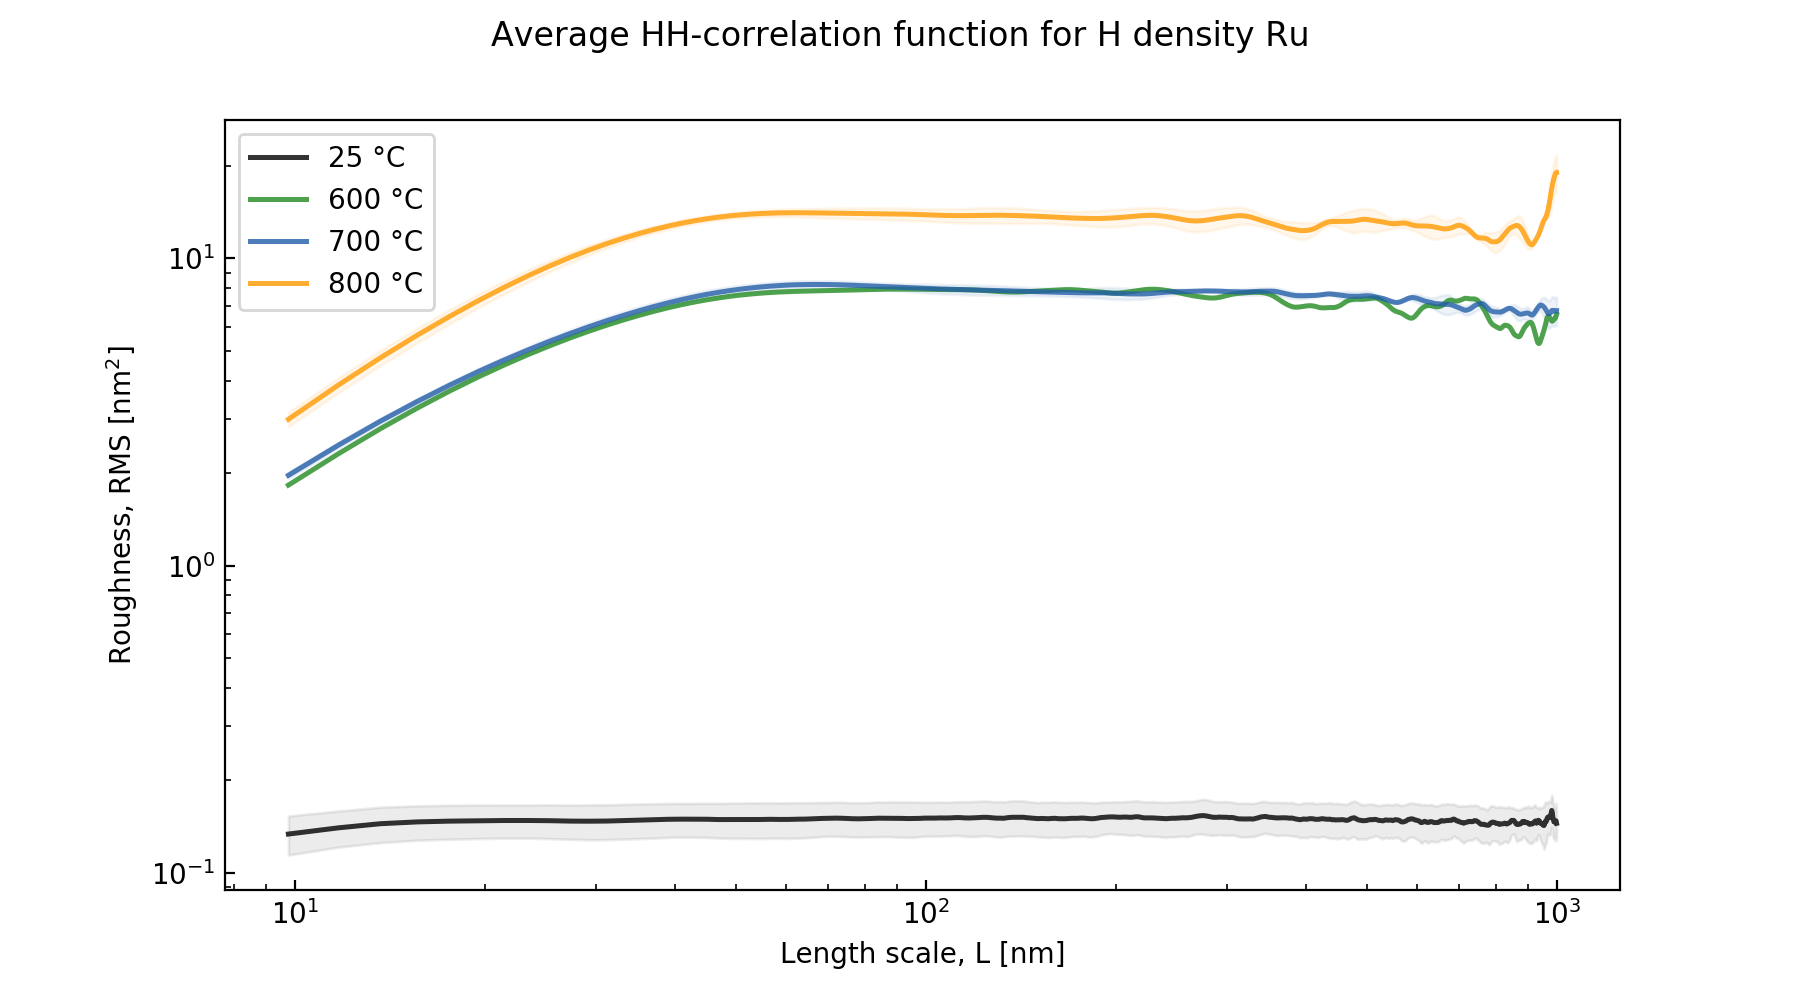

In [36]:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25', '600', '700', '800']
colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']

#select certain density:
density = 'H'

for temp, color in zip(temperatures, colors):
    
    label = f"{temp} °C"
    ax.loglog(
        x_new[density][4:],
        AvHHcorr[density][temp]['value'][4:],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )
    ax.fill_between(
        x_new[density][4:],
        AvHHcorr[density][temp]['value_lower'][4:],
        AvHHcorr[density][temp]['value_upper'][4:],
        color = color,
        alpha = 0.075
    )

    label = None
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Roughness, RMS [nm$^2$]')
ax.set(xlabel='Length scale, L [nm]')
titl = f"Average HH-correlation function for {density} density Ru"
fig.suptitle(titl)

# save figure:
figname = f"{titl}.png"
fig.savefig(f'AFM_Average HH function - Ru_{density}.png', dpi=600)


# ax.xaxis.grid() # vertical lines


# Fit the data

In [8]:
temperatures = ['25','600','700','800']
densities = df.density.unique()

interval = {}
for d in densities:
    interval [d] = {}
    for t in temperatures:
        interval[d][t]={}
        print(d,t)
        interval[d][t]['x0'] = int(input('x0 index:'))
        interval[d][t]['cutoff_idx'] = int(input('cutoff index:'))
print(interval)
interval

with open('Intervals.json', 'w') as f:
    json.dump(interval, f, indent=3)

# Interval: (x0,cutoff)
# H: 1,4  1,4  1,5   1,5   1,5    1,5
# L: 1,4  1,4  1,4   1,4   1,4    1,4 
#LH: 3,7  3,7  3,7   3,7   3,7   7,14

L 25
x0 index:1
cutoff index:4
L 600
x0 index:1
cutoff index:4
L 700
x0 index:1
cutoff index:4
L 800
x0 index:1
cutoff index:4
H 25
x0 index:1
cutoff index:4
H 600
x0 index:1
cutoff index:4
H 700
x0 index:1
cutoff index:4
H 800
x0 index:1
cutoff index:4
{'L': {'25': {'x0': 1, 'cutoff_idx': 4}, '600': {'x0': 1, 'cutoff_idx': 4}, '700': {'x0': 1, 'cutoff_idx': 4}, '800': {'x0': 1, 'cutoff_idx': 4}}, 'H': {'25': {'x0': 1, 'cutoff_idx': 4}, '600': {'x0': 1, 'cutoff_idx': 4}, '700': {'x0': 1, 'cutoff_idx': 4}, '800': {'x0': 1, 'cutoff_idx': 4}}}


In [43]:
with open('Intervals.json', 'r') as f:
    interval = json.loads(f.read()) 

# new dataframe
temperatures = ['25','600','700','800']
densities = ['L','H']

df_results = pd.DataFrame(columns= 
                   ['density',
                    'temp', 
                    'saturation',
                    'alpha',
                    'corrlen'])

Model = lambda x, a, alpha: a*x**(2*alpha)  

fit ={}
corrlen={}
for dens in densities:
    fit[dens] = {} 
    corrlen[dens]={}
    for t in temperatures:
        corrlen[dens][t]={}
        fit[dens][t]={}
        fit[dens][t]['density'] = dens
        fit[dens][t]['temperature'] = t
        fit[dens][t]['limit'] = np.mean(AvHHcorr[dens][t]['value'][50:150])
        x0 = interval[dens][t]['x0']
        cutoff_idx = interval[dens][t]['cutoff_idx']
        fit[dens][t]['results'], _ = curve_fit(
                                        Model, 
                                        x_new[dens][x0:cutoff_idx], 
                                        AvHHcorr[dens][t]['value'][x0:cutoff_idx], 
                                        sigma = None)
        a =  fit[dens][t]['results'][0]
        alpha  =  fit[dens][t]['results'][1]

        corrlen[dens][t] = (1/a*(fit[dens][t]['limit']))**(1/(2*alpha))

# *** Create new dataframe for the calculation of CorrLen and Alpha on this data:
        df_results = df_results.append( 
                {'density': fit[dens][t]['density'],
                 'temp': fit[dens][t]['temperature'],  
                 'saturation': fit[dens][t]['limit'], 
                 'alpha': alpha,
                 'corrlen': corrlen[dens][t]
                },
                ignore_index=True)
pickle.dump(df_results, open( "AvHHcorr_interpolated.p", "wb" ) )
df_results.to_excel("output_DSP_v2.xlsx")  # doctest: +SKIP


<IPython.core.display.Javascript object>


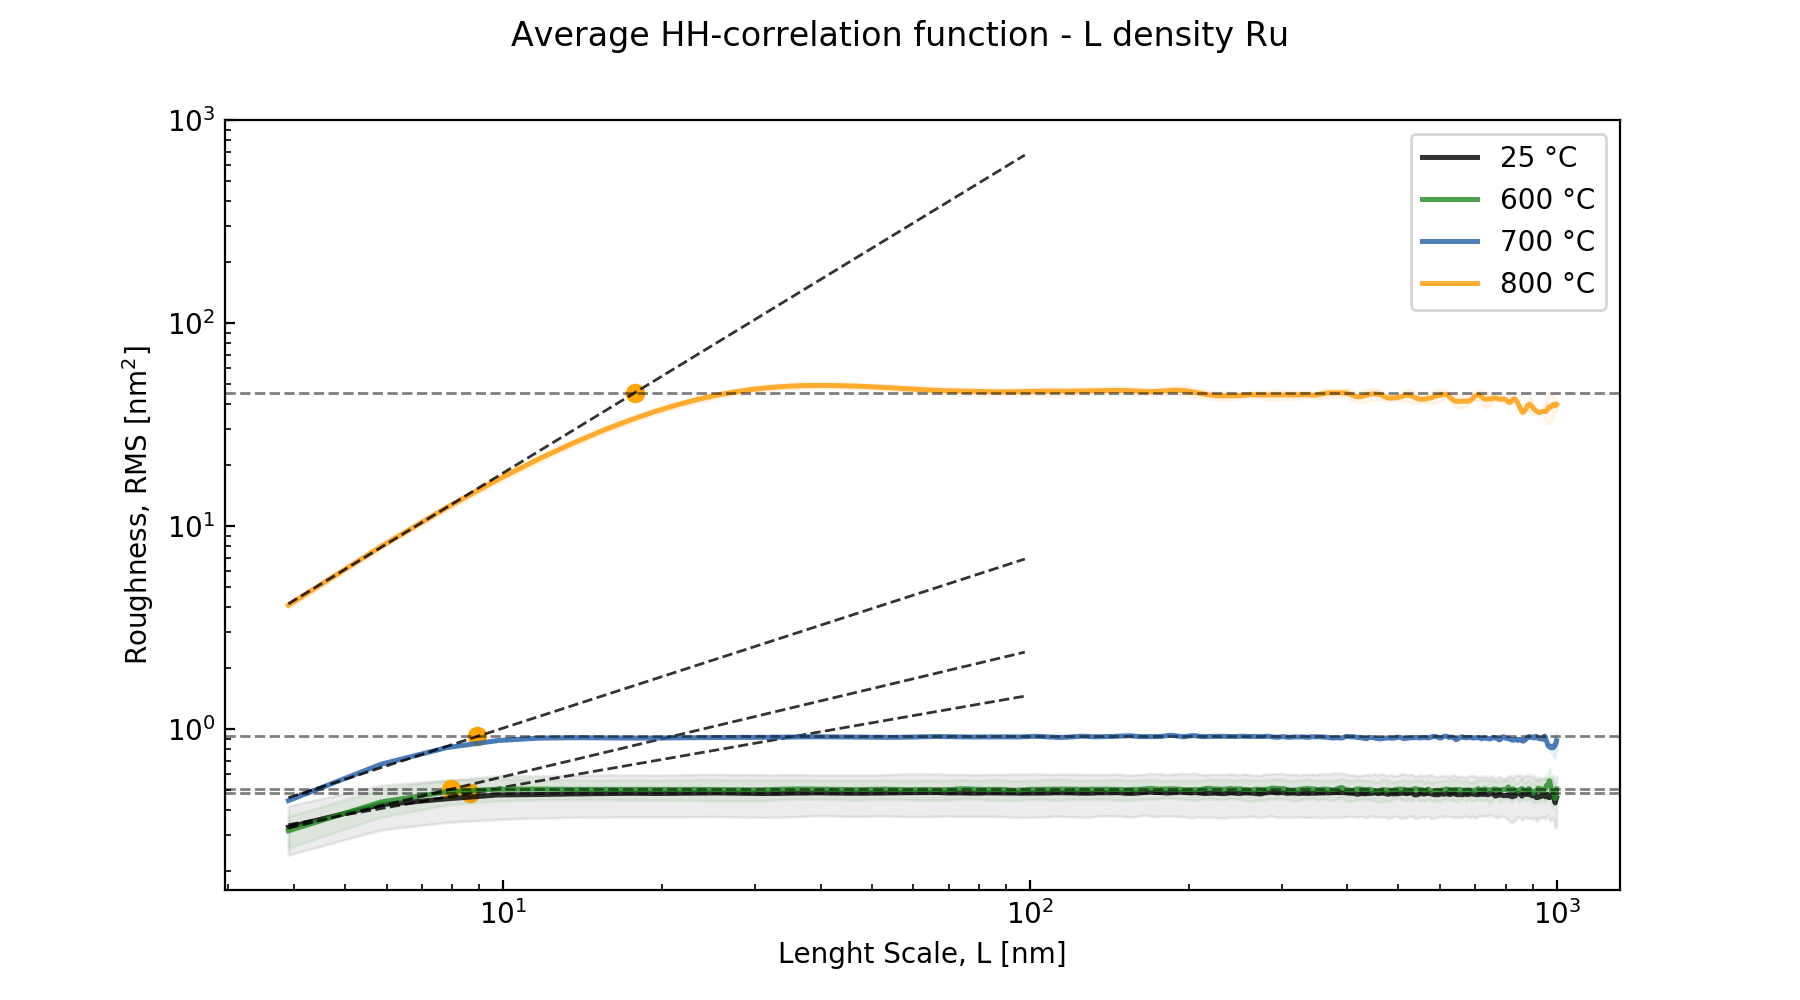

In [44]:
# *** Plot everything in one graph:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','600', '700', '800']
colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    
    density = 'L'
    
    label = f"{temp} °C"
    ax.loglog(
        x_new[density][1:],
        AvHHcorr[density][temp]['value'][1:],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )
    ax.fill_between(
        x_new[density][1:],
        AvHHcorr[density][temp]['value_lower'][1:],
        AvHHcorr[density][temp]['value_upper'][1:],
        color = color,
        alpha = 0.075
    )
    
    ax.loglog(
        x_new[density][interval[dens][temp]['x0']:50], 
        Model(x_new[density][interval[dens][temp]['x0']:50],*fit[density][temp]['results']), 
        linewidth = 1, 
        linestyle='dashed', 
        alpha = 0.8, 
        c ='k')
    ax.scatter(corrlen[density][temp], fit[density][temp]['limit'], marker='o', color='orange')
    ax.axhline(fit[density][temp]['limit'], linestyle="dashed",linewidth = 1, color = 'black', zorder =5, alpha =0.5)
    

    label = None
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Roughness, RMS [nm$^2$]')
ax.set(xlabel='Lenght Scale, L [nm]')
titl = f"Average HH-correlation function - {density} density Ru"
fig.suptitle(titl)

figname = f"{titl}.png"
fig.savefig(f'AFM_Average HH function - Ru_{density}_fit.png', dpi=600)

In [ ]:
# *** If I want to see each single HHcorr function (interpolated but not averaged)
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','600','700','800']
colors = ['black','forestgreen', '#225ea8', '#ff9900', '#ff0000', '#800000']

density='L'
for temp, color in zip(temperatures, colors):
    selection = df[df.temp==temp]
    selection = selection[selection.density==density]
    label = temp
    for idx, row in selection.iterrows():
        ax.loglog(
            x_new[density][4:],
            row.hhcorr_interp[4:],
            c = color,
            alpha = 0.6,
            linewidth = 1.4,
            label = label
        )
        ax.scatter(x_new[density][4], row.hhcorr_interp[4], c='darkblue', zorder=10)
        label = None
ax.legend()
titl = f"All HH-correlation functions in one plot - {density} density Ru"
fig.suptitle(titl)
ax.xaxis.grid() # vertical lines
figname = f"{titl}.png"
fig.savefig(f'Average HH function - {density} density Ru.png', dpi=600)



In [ ]:
# I used the following just to discard measurements that seemed to be a bit 'off'
# In the end, I kept most of the data, excluding only a few, which are indicated in the panel above, called "data exclusion"
dfT = df[df.density=='L']
df25=dfT[dfT.temp=='600']
lastitem={}
l={}
for i,row in enumerate(df25.hhcorr_interp[:]):
    print(i)
    lastitem[i] = row[-1]
    l = df25.index
    print(l)
    print(lastitem[i])
df25